<a href="https://colab.research.google.com/github/PrachiDeshkar/British-Airways-Data-Science-Project/blob/main/Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic modeling**

**Topic modeling** is a powerful Natural Language Processing technique for finding relationships among data in text documents. It falls under the category of unsupervised learning and works by representing a text document as a collection of topics (set of keywords) that best represent the prevalent contents of that document.For this project we will be using LDA.

**Latent Dirichlet Allocation (LDA)** is a popular and powerful topic modeling technique that applies generative, probabilistic models over collections of text documents. LDA treats each document as a collection of topics, and each topic is composed of a collection of words based on their probability distribution. 

In [1]:
import sys
#!{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint


Gensim is an open-source library for Natural Language Processing focusing on performing unsupervised topic modeling.

In [2]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['would','could','one','two'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
df = pd.read_csv("data/BA_reviews.csv")
#Splitting data into two columns
df[['Verification', 'reviews']] = df.reviews.str.split("|", expand = True)

In [6]:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,reviews,Verification
0,Probably the worst business class experience ...,✅ Trip Verified
1,"Definitely not recommended, especially for bu...",✅ Trip Verified
2,BA shuttle service across the UK is still su...,✅ Trip Verified
3,I must admit like many others I tend to avoid...,✅ Trip Verified
4,When will BA update their Business class cab...,Not Verified


In [7]:
#converting into string datatype 
df['reviews'] = df['reviews'].astype(str).str.lower()
df.head(3)

,reviews,Verification
0,probably the worst business class experience ...,✅ Trip Verified
1,"definitely not recommended, especially for bu...",✅ Trip Verified
2,ba shuttle service across the uk is still su...,✅ Trip Verified


## Preprocessing 

We follow the similar processing steps of Tokenization, Stopwords removal and Lemmatization. 

In [8]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.reviews.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])


[['probably', 'the', 'worst', 'business', 'class', 'experience', 'ive', 'ever', 'had', 'on', 'an', 'airline', 'just', 'few', 'of', 'the', 'issues', 'required', 'to', 'purchase', 'seats', 'on', 'international', 'club', 'world', 'business', 'class', 'this', 'was', 'not', 'made', 'known', 'during', 'the', 'ticket', 'purchase', 'process', 'and', 'cost', 'me', 'an', 'additional', 'on', 'single', 'leg', 'lhr', 'lax', 'for', 'family', 'of', 'four', 'given', 'the', 'very', 'strange', 'business', 'class', 'seating', 'layout', 'on', 'ba', 'leaving', 'the', 'seat', 'selection', 'to', 'change', 'could', 'have', 'been', 'disastrous', 'for', 'my', 'family', 'ridiculously', 'long', 'boarding', 'times', 'on', 'even', 'small', 'aircraft', 'on', 'my', 'vie', 'lhr', 'leg', 'the', 'boarding', 'time', 'for', 'the', 'was', 'over', 'minutes', 'long', 'leading', 'to', 'delayed', 'departure', 'there', 'was', 'no', 'urgency', 'on', 'the', 'part', 'of', 'staff', 'to', 'speed', 'up', 'the', 'boarding', 'times', '

A bigram model approximates the probability of a word given all the previous words by using only the conditional probability of the preceding words while a trigram model looks two words into the past. We also filter bigrams or trigrams with the filter (noun/adj, noun), (noun/adj,all types,noun/adj) because these are common structures pointing out noun-type n-grams. This helps the LDA model better cluster topics.

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


## Building LDA Model

The LDA topic model needs a dictionary and a corpus as inputs. The dictionary is simply a collection of the lemmatized words. A unique id is assigned to each word in the dictionary and used to map the frequency of each word and to produce a term document frequency corpus.

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.031*"airline" + 0.026*"seat" + 0.013*"fly" + 0.013*"travel" + '
  '0.012*"british_airway" + 0.011*"pay" + 0.011*"bag" + 0.009*"bad" + '
  '0.008*"charge" + 0.008*"staff"'),
 (1,
  '0.030*"flight" + 0.025*"seat" + 0.017*"food" + 0.016*"crew" + '
  '0.015*"service" + 0.013*"good" + 0.012*"cabin" + 0.010*"well" + '
  '0.009*"time" + 0.009*"drink"'),
 (2,
  '0.046*"flight" + 0.020*"get" + 0.017*"hour" + 0.014*"check" + 0.013*"day" + '
  '0.013*"delay" + 0.013*"tell" + 0.013*"say" + 0.012*"call" + '
  '0.010*"customer"')]


The output shows three topics (topic 0, 1 and 2), along with the top ten keywords within each topic and their importance scores. Since this is an unsupervised learning technique, it remains unclear if three is the right number of topics present in this text. 






The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords.

This way, you will know which document belongs predominantly to which topic.

In [11]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each review
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each review
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Review_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


,Review_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5657,"flight, seat, food, crew, service, good, cabin...","[probably, bad, business_class, experience, ev..."
1,1,1.0,0.6616,"flight, seat, food, crew, service, good, cabin...","[definitely, recommend, especially, business_c..."
2,2,1.0,0.7899,"flight, seat, food, crew, service, good, cabin...","[shuttle, service, still, surprisingly, good, ..."
3,3,1.0,0.7736,"flight, seat, food, crew, service, good, cabin...","[admit, many, tend, avoid, long_haul, possible..."
4,4,1.0,0.8682,"flight, seat, food, crew, service, good, cabin...","[update, business_class, cabin, much, travelli..."
5,5,1.0,0.6297,"flight, seat, food, crew, service, good, cabin...","[pay, day, flight, upgrade, economy, checkin, ..."
6,6,1.0,0.8165,"flight, seat, food, crew, service, good, cabin...","[website, work, weirdly, delete, flight, upcom..."
7,7,2.0,0.6860,"flight, get, hour, check, day, delay, tell, sa...","[absolutely, terrible, experience, british_air..."
8,8,2.0,0.7773,"flight, get, hour, check, day, delay, tell, sa...","[book, fly, new, receive, email, inform, indus..."
9,9,1.0,0.8155,"flight, seat, food, crew, service, good, cabin...","[old, narrow, pitch, flight, perfectly, time, ..."


To get samples of sentences that most represent a given topic.

In [12]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8915,"airline, seat, fly, travel, british_airway, pay, bag, bad, charge, staff","[lazy, seat, allocation, lead, husband, sit, together, understand, pay, get, seat, want, seat, n..."
1,1.0,0.9886,"flight, seat, food, crew, service, good, cabin, well, time, drink","[seat, front, section, upper_deck, feel, marginally, less, cramp, show, age, contrast, carrier, ..."
2,2.0,0.9919,"flight, get, hour, check, day, delay, tell, say, call, customer","[flight, cancel, due, technical, problem, wait, airport, hour, staying, line, hour, associate, f..."


## Word Counts of Keywords for each topic




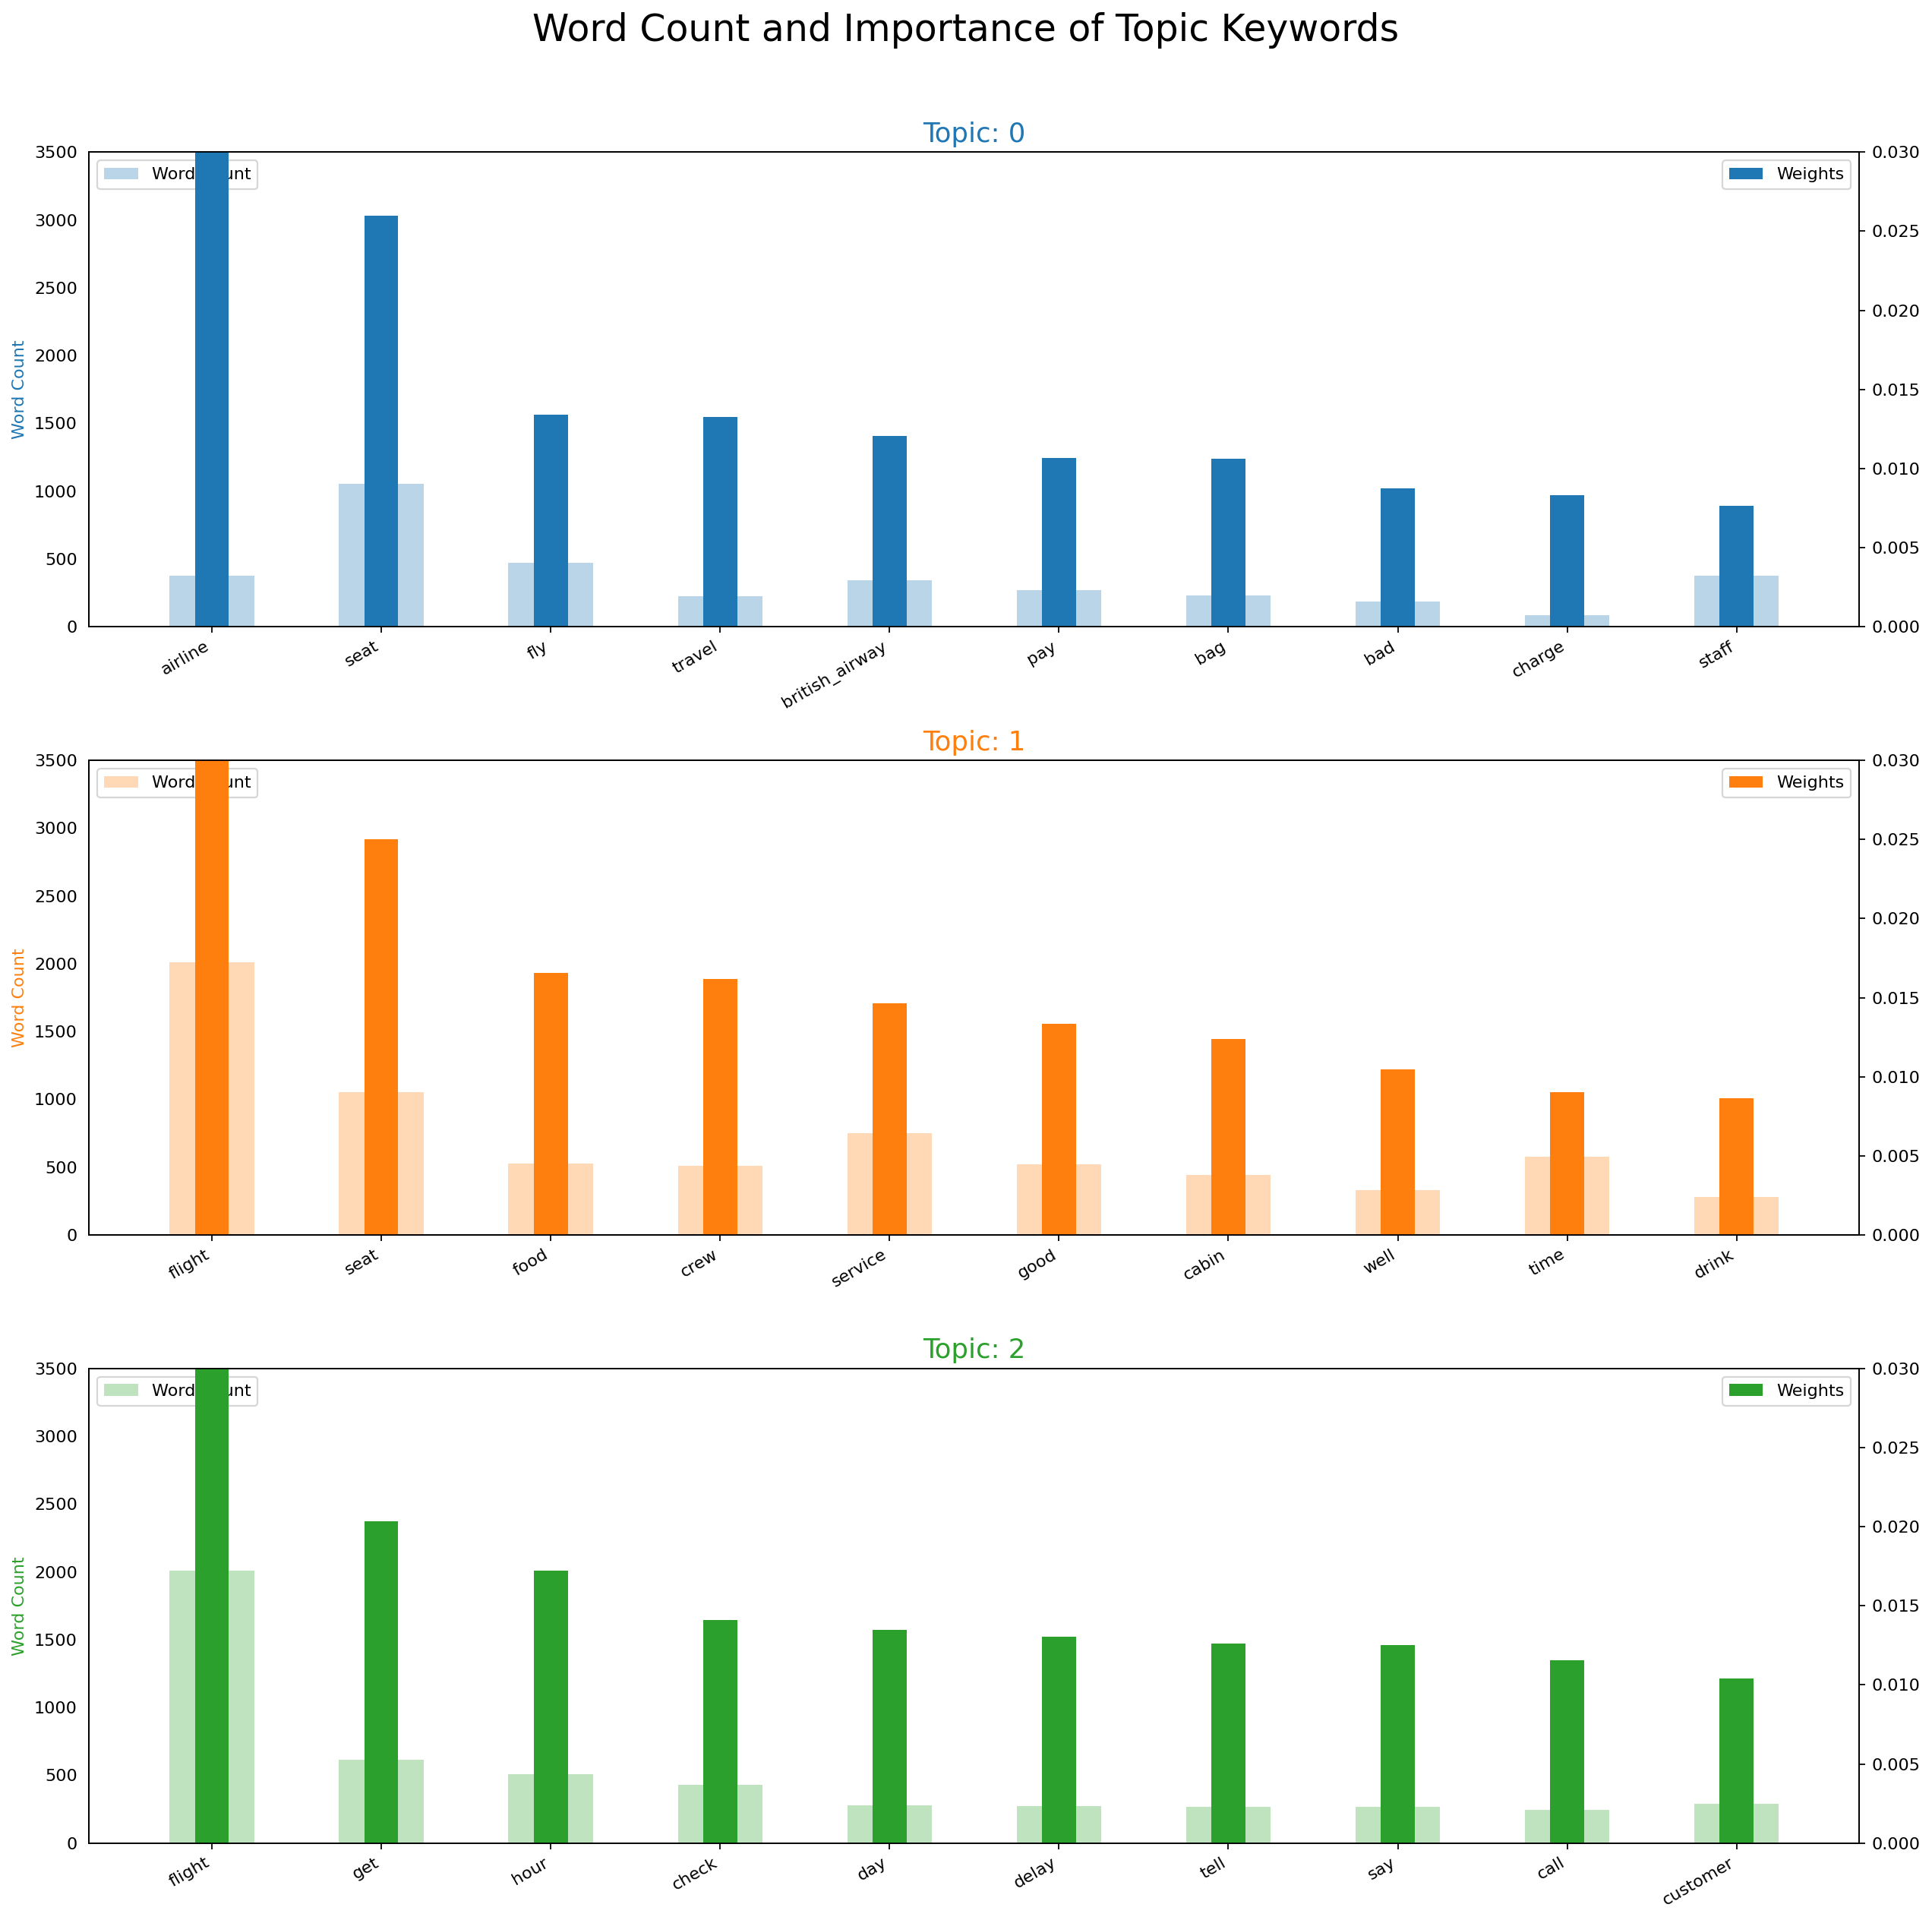

In [19]:
from collections import Counter
import matplotlib.colors as mcolors

topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, figsize=(16,15), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Sentence topic colouring

Each word in the review is representative of one of the 3 topics.
Here the color of the enclosing rectangle is the topic assigned to the document.

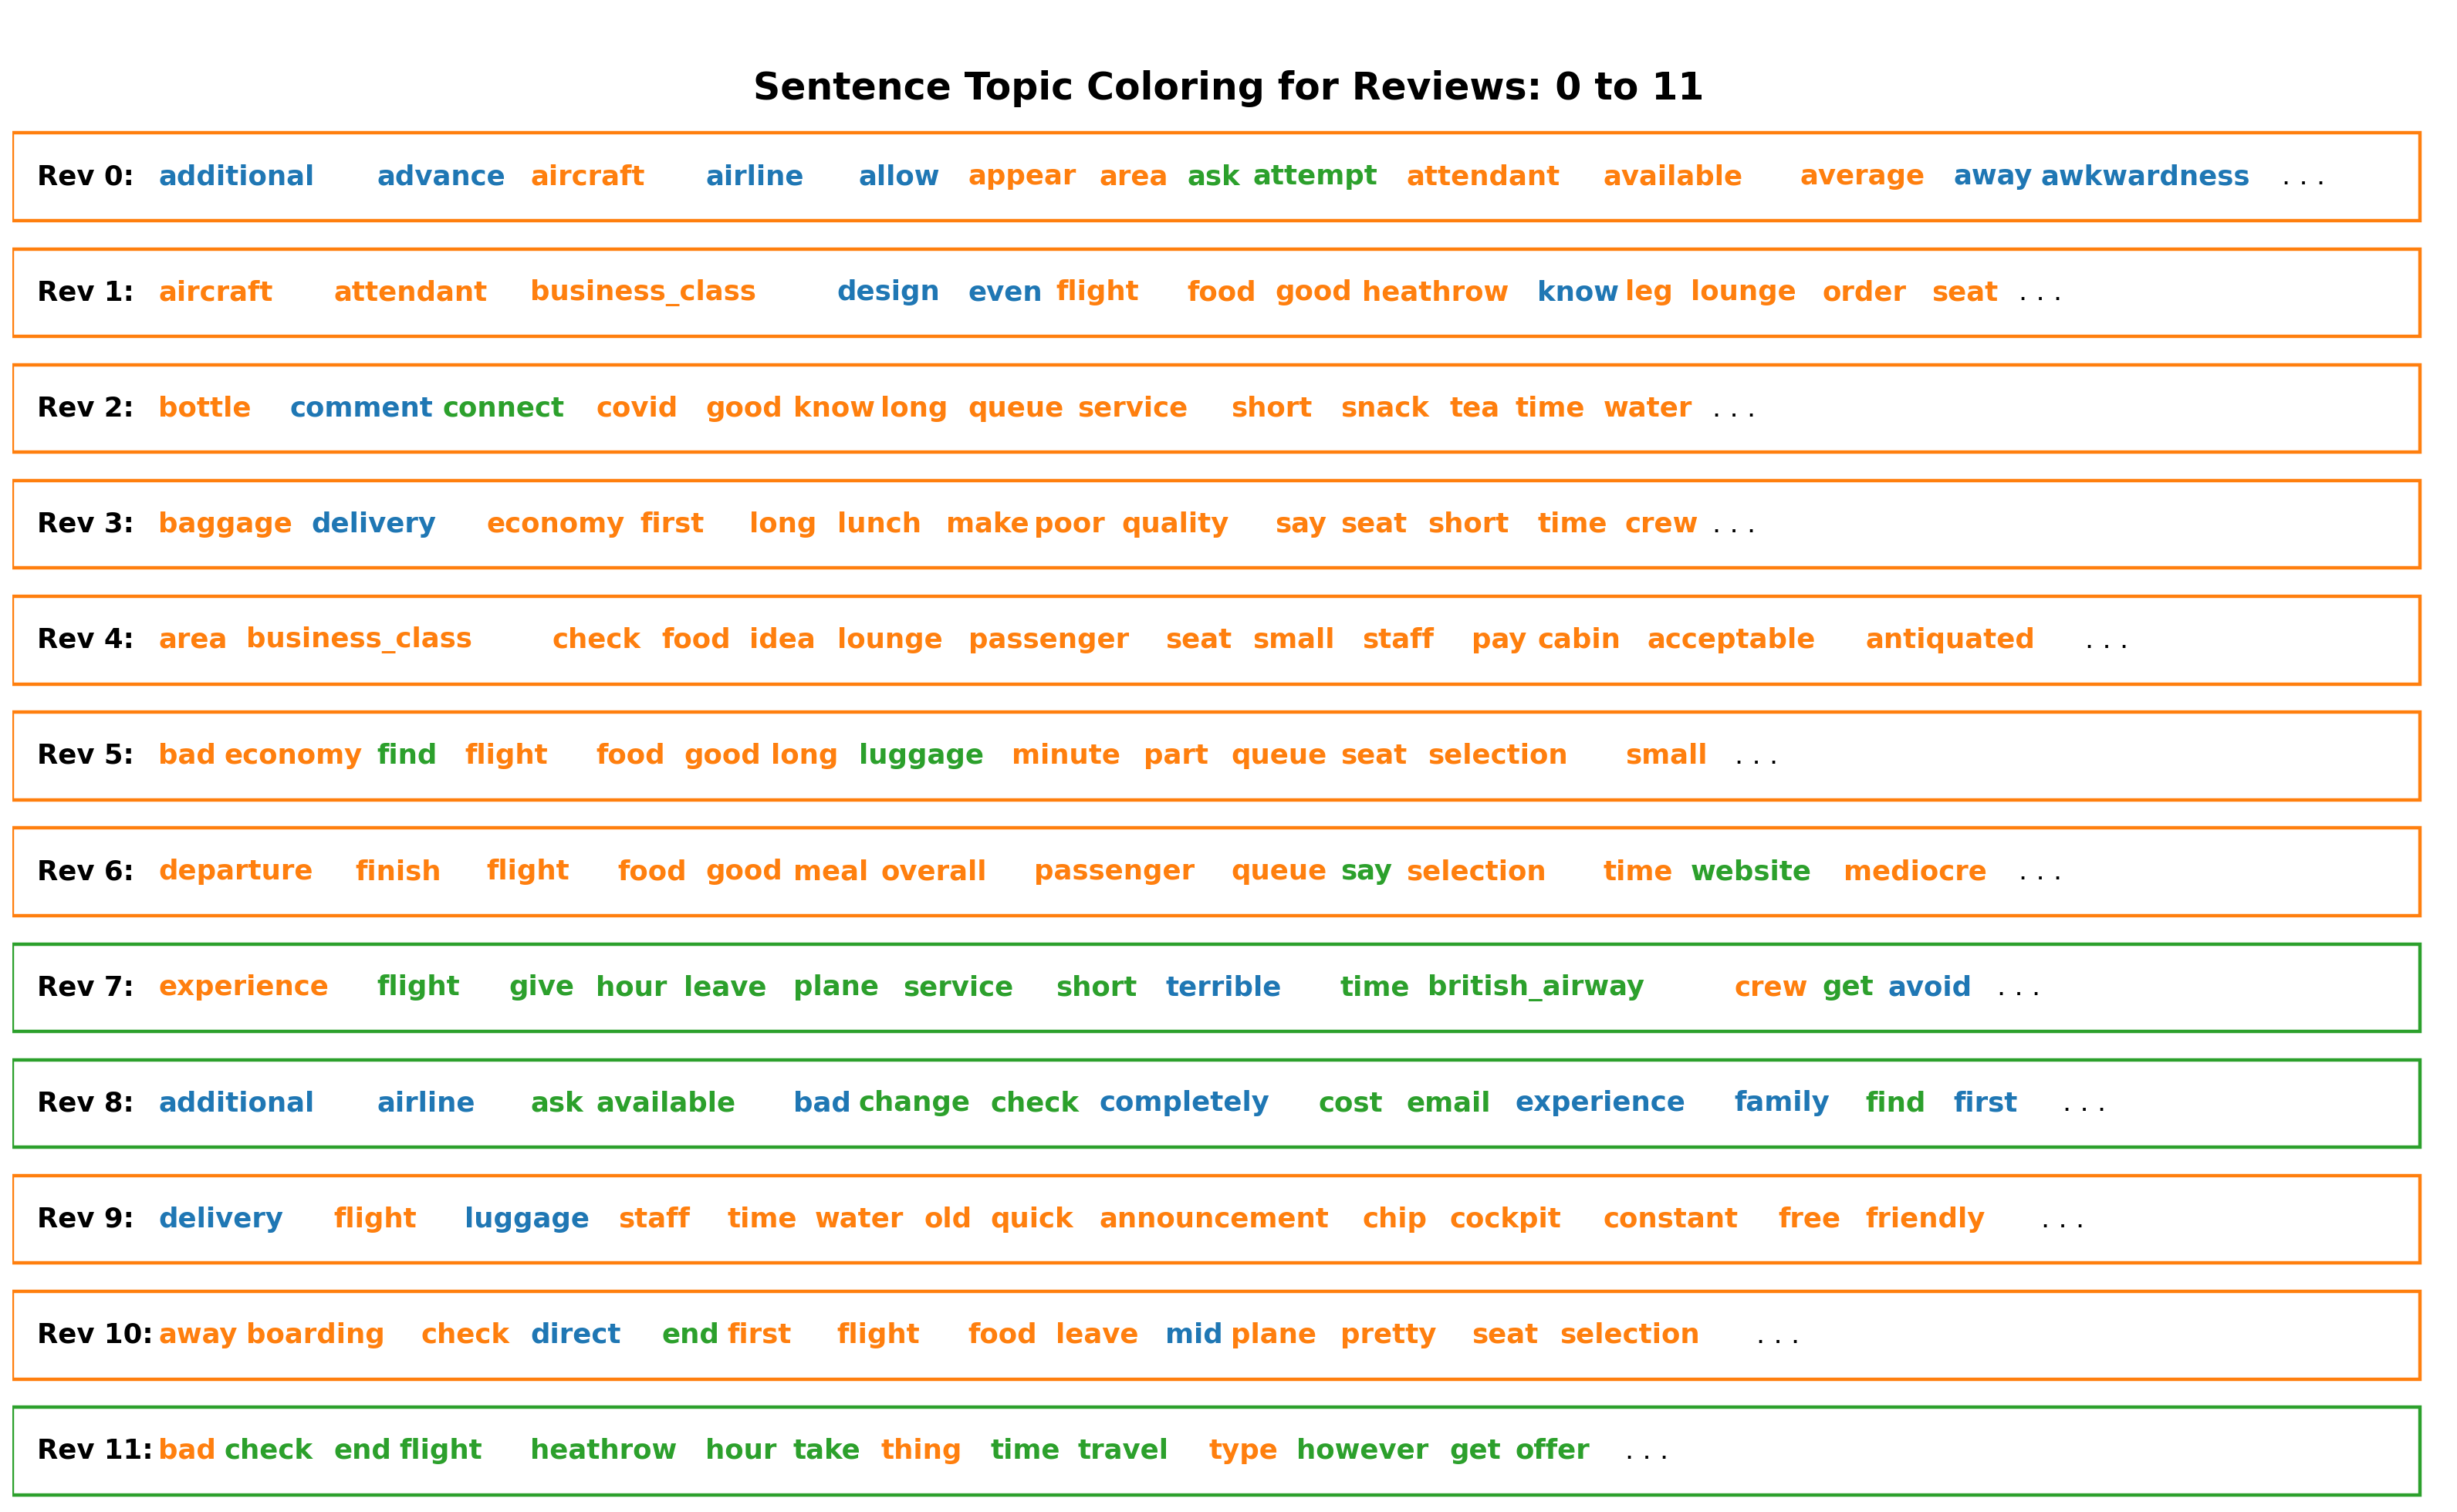

In [21]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Rev " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes) 
  
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Reviews: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()   


## Most discussed topics

In [23]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Review_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()


# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)


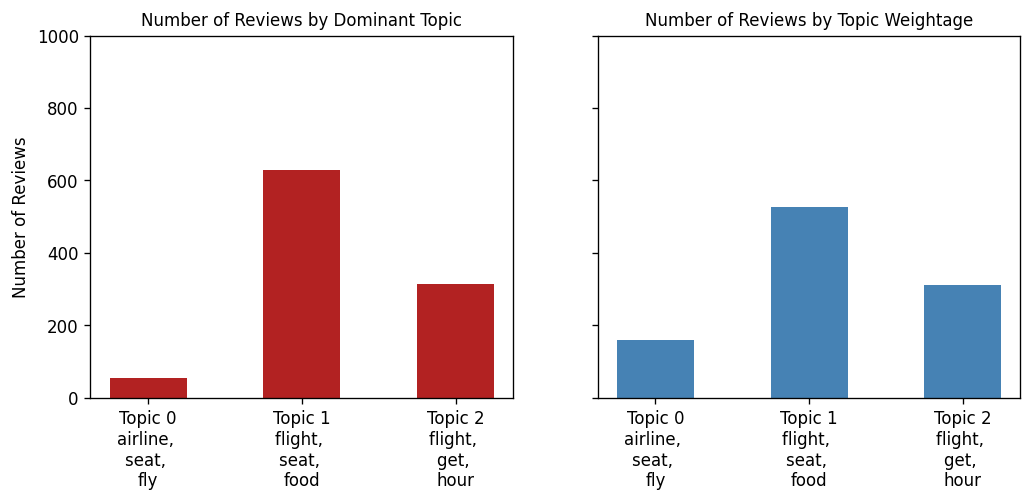

In [24]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Reviews by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Reviews')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Reviews by Topic Weightage', fontdict=dict(size=10))

plt.show()

We can see that customers discuss more about the food and seats in the flight

The pyLDAvis package is a great tool to generate an interactive chart to visualize the inter-topic distance map and examine the keywords for each topic.

When we select a topic by clicking on one of the bubbles on the left side, the overlapping red bars appear on the right side, indicating estimated frequency of each term within that topic

In [27]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.152627  0.158089       1        1  51.971634
2     -0.073784 -0.199610       2        1  32.537454
0      0.226411  0.041521       3        1  15.490912, topic_info=        Term         Freq        Total Category  logprob  loglift
138     seat  1048.000000  1048.000000  Default  30.0000  30.0000
3    airline   341.000000   341.000000  Default  29.0000  29.0000
72    flight  1895.000000  1895.000000  Default  28.0000  28.0000
74      food   530.000000   530.000000  Default  27.0000  27.0000
219     crew   518.000000   518.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
409     date    37.932380    74.800730   Topic3  -5.5273   1.1859
671   choose    37.584802    72.310228   Topic3  -5.5365   1.2106
30     check    41.795793   463.037664   Topic3  -5.4303  -0.5401
663     also    38.797958   196.964263   Topic3  -5.5048   0.2403
103     make    38.603814   220.556604   Topic3  -5.5098   0.1221

[196 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
369       3  0.948577  absolutely
0         2  0.031505  additional
0         3  0.945152  additional
1         2  0.043581     advance
1         3  0.958782     advance
...     ...       ...         ...
337       2  0.992624        wait
173       1  0.992083       water
281       1  0.955027        well
281       2  0.042762        well
2076      3  0.981027        wish

[255 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

An optimal topic model is represented by large, non-overlapping bubbles that are scattered throughout the chart. In our case the Intertopic Distance Map is optimal when the topics are three.


Using the above visualisation it is easier to generate deep insights from customer reviews using topic modelling